In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency, ttest_ind, pearsonr, f_oneway


In [ ]:
# Load relevant datasets and select columns
# Demographics (DEMO_L) for marital status, education level, and age
demo = pd.read_sas('https://wwwn.cdc.gov/Nchs/Nhanes/2021-2022/DEMO_L.XPT', format='xport')
# Blood pressure (BPX_L) for systolic and diastolic blood pressure
bp = pd.read_sas('https://wwwn.cdc.gov/Nchs/Nhanes/2021-2022/BPXO_L.XPT', format='xport')
# Hepatitis B (HEPB_L) for Hepatitis B lab antibodies
hepb = pd.read_sas('https://wwwn.cdc.gov/Nchs/Nhanes/2021-2022/HEPB_S_L.XPT', format='xport')
# Kidney conditions questionnaire (KIQ_L) for weak/failing kidneys
kiq = pd.read_sas('https://wwwn.cdc.gov/Nchs/Nhanes/2021-2022/KIQ_U_L.XPT', format='xport')
# Physical activity (PAQ_L) for sedentary behavior
paq = pd.read_sas('https://wwwn.cdc.gov/Nchs/Nhanes/2021-2022/PAQ_L.XPT', format='xport')
# Vitamin D (VID_L) for vitamin D lab interpretation
vid = pd.read_sas('https://wwwn.cdc.gov/Nchs/Nhanes/2021-2022/VID_L.XPT', format='xport')
# Weight (WHQ_L) for current self-reported weight
whq = pd.read_sas('https://wwwn.cdc.gov/Nchs/Nhanes/2021-2022/WHQ_L.XPT', format='xport')

In [ ]:
# Start with the first dataset
df = demo[['SEQN', 'DMDMARTZ', 'DMDEDUC2', 'RIDAGEYR']]

# Merge with each additional dataset using 'SEQN' as the key
df = df.merge(bp[['SEQN', 'BPXOSY3', 'BPXODI3']], on='SEQN', how='left')
df = df.merge(hepb[['SEQN', 'LBXHBS']], on='SEQN', how='left')
df = df.merge(kiq[['SEQN', 'KIQ022']], on='SEQN', how='left')
df = df.merge(paq[['SEQN', 'PAD680']], on='SEQN', how='left')
df = df.merge(vid[['SEQN', 'LBDVD2LC']], on='SEQN', how='left')
df = df.merge(whq[['SEQN', 'WHD020']], on='SEQN', how='left')

# Display the merged table
df.head()


,SEQN,DMDMARTZ,DMDEDUC2,RIDAGEYR,BPXOSY3,BPXODI3,LBXHBS,KIQ022,PAD680,LBDVD2LC,WHD020
0,130378.0,1.0,5.0,43.0,132.0,94.0,2.0,2.0,360.0,1.0,190.0
1,130379.0,1.0,5.0,66.0,113.0,76.0,2.0,2.0,480.0,1.0,220.0
2,130380.0,1.0,3.0,44.0,104.0,76.0,2.0,2.0,240.0,1.0,150.0
3,130381.0,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,130382.0,NaN,NaN,2.0,NaN,NaN,2.0,NaN,NaN,NaN,NaN


In [ ]:
# Recode categorical variables to prepare them for analysis
# Recode Marital Status (1 as 'Married', others as 'Not Married')
df['Marital_Status'] = df['DMDMARTZ'].apply(lambda x: 'Married' if x == 1 else 'Not Married')
# Recode Education Level (4 and above as 'Bachelor\'s or Higher', others as 'Less than Bachelor\'s')
df['Education_Level'] = df['DMDEDUC2'].apply(lambda x: 'Bachelor\'s or Higher' if x >= 4 else 'Less than Bachelor\'s')
# Recode Vitamin D Level (1 as 'Low', others as 'High')
df['VitaminD_Level'] = df['LBDVD2LC'].apply(lambda x: 'Low' if x == 1 else 'High')
# Recode Hepatitis B Antibodies (1 as 'Positive', others as 'Negative')
df['HepB_Antibodies'] = df['LBXHBS'].apply(lambda x: 'Positive' if x == 1 else 'Negative')
# Recode Kidney Status (1 as 'Yes', 2 as 'No', others as 'Unknown')
df['Kidney_Status'] = df['KIQ022'].apply(lambda x: 'Yes' if x == 1 else ('No' if x == 2 else 'Unknown'))

df.head()

,SEQN,DMDMARTZ,DMDEDUC2,RIDAGEYR,BPXOSY3,BPXODI3,LBXHBS,KIQ022,PAD680,LBDVD2LC,WHD020,Marital_Status,Education_Level,VitaminD_Level,HepB_Antibodies,Kidney_Status
0,130378.0,1.0,5.0,43.0,132.0,94.0,2.0,2.0,360.0,1.0,190.0,Married,Bachelor's or Higher,Low,Negative,No
1,130379.0,1.0,5.0,66.0,113.0,76.0,2.0,2.0,480.0,1.0,220.0,Married,Bachelor's or Higher,Low,Negative,No
2,130380.0,1.0,3.0,44.0,104.0,76.0,2.0,2.0,240.0,1.0,150.0,Married,Less than Bachelor's,Low,Negative,No
3,130381.0,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Not Married,Less than Bachelor's,High,Negative,Unknown
4,130382.0,NaN,NaN,2.0,NaN,NaN,2.0,NaN,NaN,NaN,NaN,Not Married,Less than Bachelor's,High,Negative,Unknown


In [ ]:
# Clean continuous variables by handling placeholder values and dropping NaNs
# Replace placeholder values (7777 and 9999) in PAD680 (Sedentary Behavior) with NaN, then drop rows with NaNs
df['PAD680'] = df['PAD680'].replace([7777, 9999], np.nan).dropna()
# Replace placeholder values (7777 and 9999) in WHD020 (Self-Reported Weight) with NaN, then drop rows with NaNs
df['WHD020'] = df['WHD020'].replace([7777, 9999], np.nan).dropna()
# Drop any NaN values in RIDAGEYR (Age), as this is a required field for analysis
df['RIDAGEYR'] = df['RIDAGEYR'].dropna()
# Drop any NaN values in BPXOSY3 (Systolic Blood Pressure), required for analysis
df['BPXOSY3'] = df['BPXOSY3'].dropna()
# Drop any NaN values in BPXODI3 (Diastolic Blood Pressure), required for analysis
df['BPXODI3'] = df['BPXODI3'].dropna()


In [ ]:
# Check frequency counts for categorical variables to ensure data consistency
# Display the count of each category for Marital_Status to ensure proper recoding
print(df['Marital_Status'].value_counts())
# Display the count of each category for Education_Level to confirm accuracy after recoding
print(df['Education_Level'].value_counts())
# Display the count of each category for VitaminD_Level to confirm appropriate recoding
print(df['VitaminD_Level'].value_counts())
# Display the count of each category for HepB_Antibodies to confirm correct recoding
print(df['HepB_Antibodies'].value_counts())


Marital_Status
Not Married    7797
Married        4136
Name: count, dtype: int64
Education_Level
Less than Bachelor's    6927
Bachelor's or Higher    5006
Name: count, dtype: int64
VitaminD_Level
High    6073
Low     5860
Name: count, dtype: int64
HepB_Antibodies
Negative    9891
Positive    2042
Name: count, dtype: int64


In [ ]:
# Check summary statistics for continuous variables to understand their distributions
# Show descriptive statistics for RIDAGEYR (Age) to verify data distribution
print(df['RIDAGEYR'].describe())
# Show descriptive statistics for BPXOSY3 (Systolic Blood Pressure) to assess data range and outliers
print(df['BPXOSY3'].describe())
# Show descriptive statistics for BPXODI3 (Diastolic Blood Pressure) to examine data distribution
print(df['BPXODI3'].describe())
# Show descriptive statistics for PAD680 (Sedentary Behavior Time) to check for data variability
print(df['PAD680'].describe())
# Show descriptive statistics for WHD020 (Self-Reported Weight) to assess data range and any anomalies
print(df['WHD020'].describe())


count    1.193300e+04
mean     3.831786e+01
std      2.560199e+01
min      5.397605e-79
25%      1.300000e+01
50%      3.700000e+01
75%      6.200000e+01
max      8.000000e+01
Name: RIDAGEYR, dtype: float64
count    7480.000000
mean      118.917647
std        18.495220
min        50.000000
25%       106.000000
50%       116.000000
75%       129.000000
max       232.000000
Name: BPXOSY3, dtype: float64
count    7480.000000
mean       71.805882
std        11.767402
min        24.000000
25%        64.000000
50%        71.000000
75%        79.000000
max       136.000000
Name: BPXODI3, dtype: float64
count    8.065000e+03
mean     3.621761e+02
std      2.100268e+02
min      5.397605e-79
25%      1.800000e+02
50%      3.000000e+02
75%      4.800000e+02
max      1.380000e+03
Name: PAD680, dtype: float64
count    8358.000000
mean      179.502273
std        48.115718
min        63.000000
25%       145.000000
50%       173.000000
75%       205.000000
max       530.000000
Name: WHD020, dtype: flo

In [ ]:
df.to_csv('cleaned_nhanes_data.csv', index=False)


In [ ]:
# Question 1: Association between Marital Status and Education Level
# Statistical Test: Chi-square test
contingency_table = pd.crosstab(df['Marital_Status'], df['Education_Level'])
chi2, p, dof, ex = chi2_contingency(contingency_table)
print(f"Chi-square: {chi2}, p-value: {p}")



Chi-square: 1670.19828938441, p-value: 0.0


---

### Question 1: Association between Marital Status and Education Level
> **Statistical Test**: Chi-square test

- **Chi-square statistic**: 1670.20
- **p-value**: 0.0 (significant at p < 0.05)

**Interpretation**:  
The Chi-square test suggests a significant association between Marital Status and Education Level. This means that education level distribution is not independent of marital status in this dataset.

---








In [ ]:
# Question 2: Difference in Mean Sedentary Behavior Time by Marital Status
# Statistical Test: Independent t-test.
# Filter for 'Married' and 'Not Married', dropping any NaN values in PAD680
married = df[df['Marital_Status'] == 'Married']['PAD680'].dropna()
not_married = df[df['Marital_Status'] == 'Not Married']['PAD680'].dropna()

# Perform the t-test
t_stat, p_value = ttest_ind(married, not_married)
print(f"T-statistic: {t_stat}, p-value: {p_value}")



T-statistic: -3.8740971309213887, p-value: 0.0001078679819334709


---

### Question 2: Difference in Mean Sedentary Behavior Time by Marital Status
> **Statistical Test**: Independent t-test

- **t-statistic**: -3.87
- **p-value**: 0.0001 (significant at p < 0.05)

**Interpretation**:  
The t-test indicates a significant difference in sedentary behavior time between married and not married individuals, with married individuals having lower average sedentary time.

---

In [ ]:
# Question 3: Impact of Age and Marital Status on Systolic Blood Pressure
# Statistical Test: Two-way ANOVA
import statsmodels.api as sm
from statsmodels.formula.api import ols

model = ols('BPXOSY3 ~ C(Marital_Status) * RIDAGEYR', data=df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)


                                  sum_sq      df            F    PR(>F)
C(Marital_Status)           1.737748e+03     1.0     6.861396  0.008826
RIDAGEYR                    5.889160e+05     1.0  2325.300570  0.000000
C(Marital_Status):RIDAGEYR  3.856374e+02     1.0     1.522667  0.217255
Residual                    1.893405e+06  7476.0          NaN       NaN


---

### Question 3: Impact of Age and Marital Status on Systolic Blood Pressure
> **Statistical Test**: Two-way ANOVA

- **Marital Status**: Significant effect (p = 0.0088)
- **Age**: Highly significant effect (p < 0.0001)
- **Interaction (Marital Status * Age)**: Not significant (p = 0.217)

**Interpretation**:  
Both Age and Marital Status independently impact Systolic Blood Pressure. However, there’s no significant interaction effect, meaning the effect of Age on Systolic Blood Pressure is consistent across marital statuses.

---

In [ ]:
# Question 4: Correlation between Self-Reported Weight and Sedentary Behavior
# Statistical Test: Pearson correlation
# Drop rows with NaN values in WHD020 and PAD680
df_cleaned = df[['WHD020', 'PAD680']].dropna()

# Perform Pearson correlation on the cleaned data
corr, p_value = pearsonr(df_cleaned['WHD020'], df_cleaned['PAD680'])
print(f"Pearson Correlation: {corr}, p-value: {p_value}")



Pearson Correlation: 0.1559714584645021, p-value: 1.6988498386828133e-44


---

### Question 4: Correlation between Self-Reported Weight and Sedentary Behavior
> **Statistical Test**: Pearson correlation

- **Pearson Correlation Coefficient**: 0.156
- **p-value**: < 0.0001 (significant)

**Interpretation**:  
There is a weak but statistically significant positive correlation between self-reported weight and sedentary behavior time, indicating a slight tendency for heavier individuals to have more sedentary time.

---


In [ ]:
# Question 5: Is there a significant difference in diastolic blood pressure between those with and without weak/failing kidneys?
# Statistical Test: Independent t-test
# Filter for participants with and without kidney issues, dropping any NaN values in BPXODI3
with_kidney_issue = df[(df['KIQ022'] == 1) & (df['BPXODI3'].notna())]['BPXODI3']
without_kidney_issue = df[(df['KIQ022'] == 2) & (df['BPXODI3'].notna())]['BPXODI3']

# Perform the t-test
t_stat, p_value = ttest_ind(with_kidney_issue, without_kidney_issue)
print(f"T-statistic: {t_stat}, p-value: {p_value}")



T-statistic: -4.825487016983081, p-value: 1.4321801501025331e-06


---

### Question 5: Difference in Diastolic Blood Pressure by Kidney Status
> **Statistical Test**: Independent t-test

- **t-statistic**: -4.83
- **p-value**: < 0.0001 (significant)

**Interpretation**:  
The t-test shows a significant difference in diastolic blood pressure between individuals with and without kidney issues, with those having kidney issues showing lower diastolic blood pressure.

---

In [ ]:
# Step 5: Visualizations

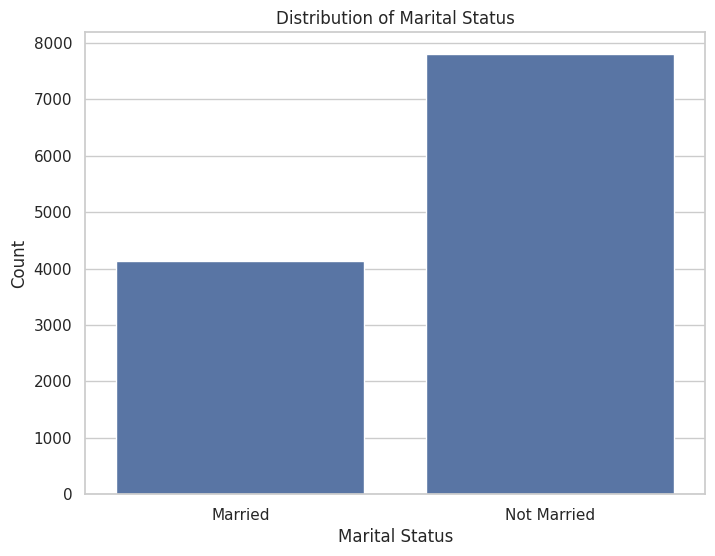

In [ ]:
# Bar chart for Marital Status distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='Marital_Status', data=df)
plt.title("Distribution of Marital Status")
plt.xlabel("Marital Status")
plt.ylabel("Count")
plt.show()

### Visualization of Marital Status Distribution
The bar chart above shows the distribution of marital status in the dataset, giving an overview of the number of married vs. not married individuals.


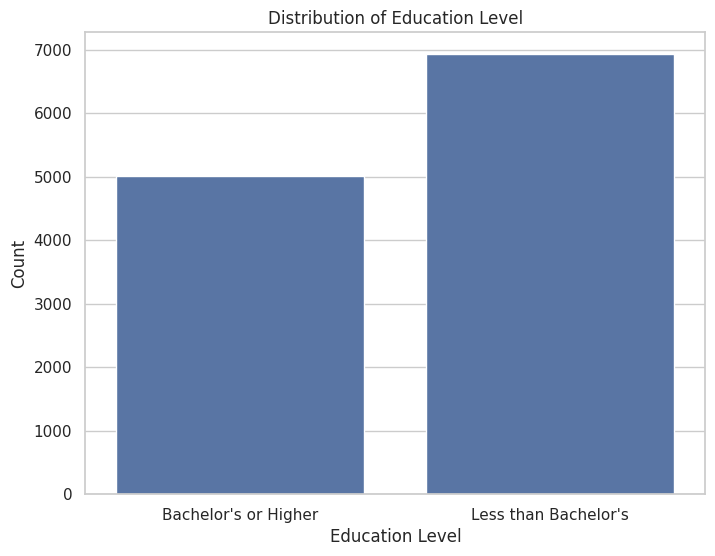

In [ ]:
# Bar chart for Education Level distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='Education_Level', data=df)
plt.title("Distribution of Education Level")
plt.xlabel("Education Level")
plt.ylabel("Count")
plt.show()

### Visualization of Education Level Distribution
This bar chart represents the distribution of education levels in the dataset, showing the number of individuals with a bachelor's degree or higher versus those with less than a bachelor's degree.


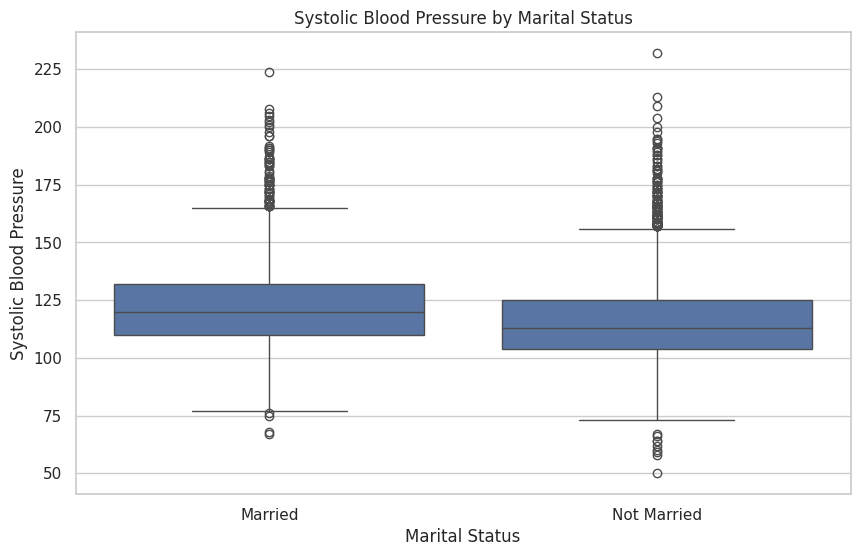

In [ ]:
# Boxplot for Systolic Blood Pressure by Marital Status
plt.figure(figsize=(10, 6))
sns.boxplot(x='Marital_Status', y='BPXOSY3', data=df)
plt.title("Systolic Blood Pressure by Marital Status")
plt.xlabel("Marital Status")
plt.ylabel("Systolic Blood Pressure")
plt.show()

### Visualization of Systolic Blood Pressure by Marital Status
The boxplot above compares the systolic blood pressure distribution between married and not married individuals, showing differences in blood pressure levels.


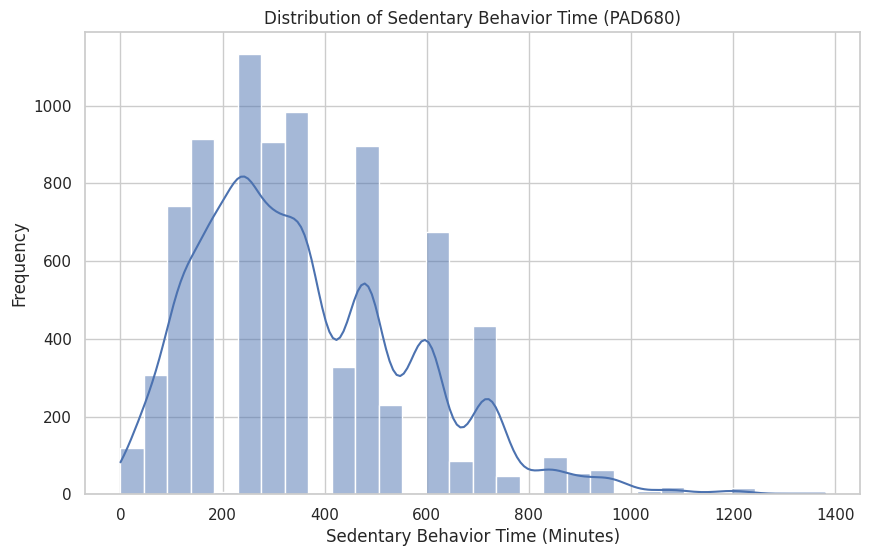

In [ ]:
# Histogram for Sedentary Behavior Time
plt.figure(figsize=(10, 6))
sns.histplot(df['PAD680'].dropna(), kde=True, bins=30)
plt.title("Distribution of Sedentary Behavior Time (PAD680)")
plt.xlabel("Sedentary Behavior Time (Minutes)")
plt.ylabel("Frequency")
plt.show()


### Visualization of Sedentary Behavior Time Distribution
The histogram above displays the distribution of sedentary behavior time (in minutes) across individuals, providing insights into the levels of physical inactivity in the dataset.


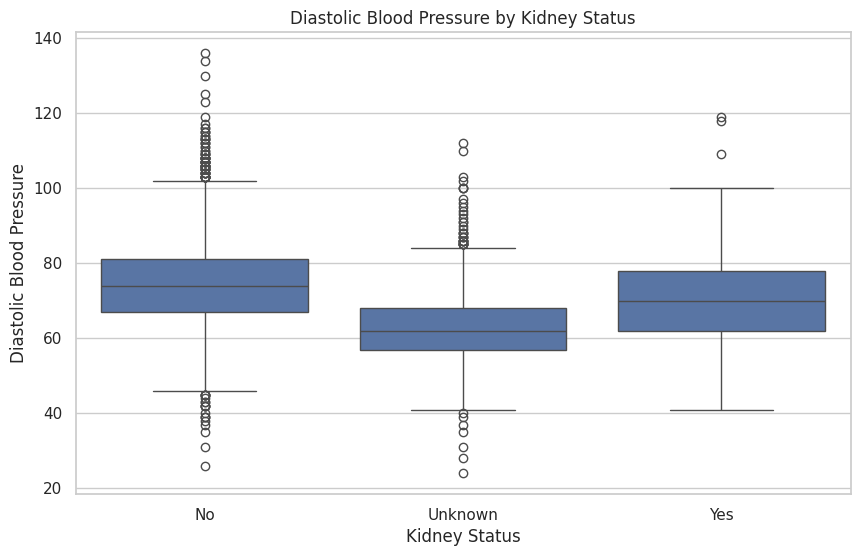

In [ ]:
# Boxplot for Diastolic Blood Pressure by Kidney Status
plt.figure(figsize=(10, 6))
sns.boxplot(x='Kidney_Status', y='BPXODI3', data=df)
plt.title("Diastolic Blood Pressure by Kidney Status")
plt.xlabel("Kidney Status")
plt.ylabel("Diastolic Blood Pressure")
plt.show()

### Visualization of Diastolic Blood Pressure by Kidney Status
The boxplot above compares diastolic blood pressure between individuals with and without kidney issues, highlighting any differences based on kidney health status.
